Column description:\
**city** - the name of the city where the property is located\
**type** - type of the building\
**squareMeters** - the size of the apartment in square meters\
**rooms** - number of rooms in the apartment\
**floor / floorCount** - the floor where the apartment is located and the total number of floors in the building\
**buildYear** - the year when the building was built\
**latitude, longitude** - geo coordinate of the property\
**centreDistance** - distance from the city centre in km\
**poiCount** - number of points of interest in 500m range from the apartment (schools, clinics, post offices, kindergartens, restaurants, colleges, pharmacies)\
**[poiName]Distance** - distance to the nearest point of interest (schools, clinics, post offices, kindergartens, restaurants, colleges, pharmacies)\
**ownership** - the type of property ownership\
**condition** - the condition of the apartment\
**has[features]** - whether the property has key features such as assigned parking space, balcony, elevator, security, storage room\
**price** - offer price in Polish Zloty

apartments_pl_YYYY_MM.csv: sale price


In [2]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
path = "/content/drive/MyDrive/Data Analysis/Apartments-Prices-in-Poland/apartments_pl_2024_06.csv"

df_all = pd.read_csv(path)

In [5]:
df_all.head()

,id,city,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,...,pharmacyDistance,ownership,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price
0,811891f98a870dfd6e414374a0a85560,szczecin,blockOfFlats,47.00,2.0,6.0,12.0,1981.0,53.428544,14.552812,...,0.085,condominium,concreteSlab,NaN,no,yes,yes,no,yes,449000
1,adaf636d0c44d8d9325bce42403eefee,szczecin,apartmentBuilding,88.22,3.0,1.0,2.0,2000.0,53.449093,14.516844,...,0.668,condominium,brick,premium,yes,yes,no,no,no,950000
2,9b957bd60885a469c96f17b58a914f4b,szczecin,apartmentBuilding,117.00,5.0,4.0,4.0,NaN,53.443096,14.561348,...,0.229,udział,brick,premium,yes,yes,no,no,no,1099000
3,74fef2ff7135bc70797a3fbfd7d44ed6,szczecin,blockOfFlats,33.31,1.0,1.0,4.0,1963.0,53.436100,14.541200,...,0.388,cooperative,brick,NaN,yes,no,no,yes,yes,380000
4,77cc78c75b0d09bf84d6d3124a28803c,szczecin,blockOfFlats,56.00,3.0,7.0,7.0,2018.0,53.447465,14.557811,...,0.178,condominium,brick,premium,yes,yes,yes,yes,yes,799000


# Explore and prepare

In [6]:
fig = px.scatter_mapbox(
    df_all,
    lat=df_all['latitude'],
    lon=df_all['longitude'],
    width=600,
    height=600,
    color='price',
    hover_data=["price"],
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()


In [7]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21501 entries, 0 to 21500
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    21501 non-null  object 
 1   city                  21501 non-null  object 
 2   type                  17104 non-null  object 
 3   squareMeters          21501 non-null  float64
 4   rooms                 21501 non-null  float64
 5   floor                 17928 non-null  float64
 6   floorCount            21292 non-null  float64
 7   buildYear             18121 non-null  float64
 8   latitude              21501 non-null  float64
 9   longitude             21501 non-null  float64
 10  centreDistance        21501 non-null  float64
 11  poiCount              21501 non-null  float64
 12  schoolDistance        21490 non-null  float64
 13  clinicDistance        21438 non-null  float64
 14  postOfficeDistance    21481 non-null  float64
 15  kindergartenDistanc

Check the number of apartments per city

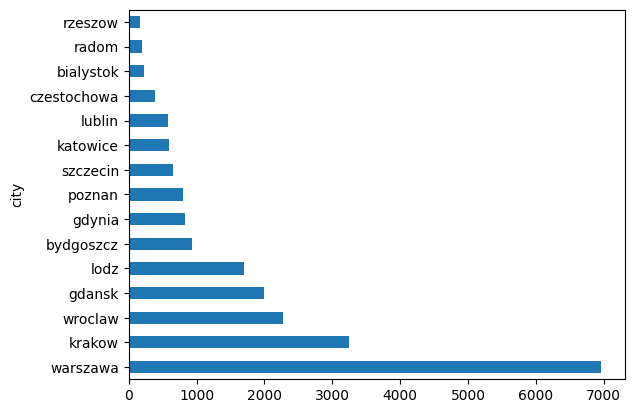

In [8]:
df_all['city'].value_counts().plot(kind='barh');

## Let's focus on Krakow data.

In [9]:
df = df_all[df_all['city'] == 'krakow']

Drop 'id' and 'city' column

In [10]:
df = df.drop(columns=['id', 'city'])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3245 entries, 1475 to 4719
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  2748 non-null   object 
 1   squareMeters          3245 non-null   float64
 2   rooms                 3245 non-null   float64
 3   floor                 2592 non-null   float64
 4   floorCount            3210 non-null   float64
 5   buildYear             2772 non-null   float64
 6   latitude              3245 non-null   float64
 7   longitude             3245 non-null   float64
 8   centreDistance        3245 non-null   float64
 9   poiCount              3245 non-null   float64
 10  schoolDistance        3245 non-null   float64
 11  clinicDistance        3237 non-null   float64
 12  postOfficeDistance    3245 non-null   float64
 13  kindergartenDistance  3245 non-null   float64
 14  restaurantDistance    3245 non-null   float64
 15  collegeDistance       3

In [12]:
df.nunique()

,0
type,3
squareMeters,1238
rooms,6
floor,14
floorCount,18
buildYear,129
latitude,2105
longitude,2157
centreDistance,778
poiCount,145


Check for duplicated rows

In [13]:
duplicates = df[df.duplicated(keep=False)]
duplicates

,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,...,pharmacyDistance,ownership,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price
1592,tenement,64.00,3.0,1.0,4.0,1935.0,50.070954,19.923942,2.03,21.0,...,0.233,condominium,brick,NaN,no,yes,yes,no,yes,1290000
1651,blockOfFlats,33.31,2.0,2.0,4.0,2023.0,50.077788,19.924889,2.68,23.0,...,0.080,condominium,brick,NaN,no,yes,no,no,no,650000
1702,blockOfFlats,49.50,3.0,9.0,11.0,1975.0,50.021466,20.008347,6.25,2.0,...,0.541,cooperative,concreteSlab,NaN,no,yes,yes,no,yes,659000
1719,blockOfFlats,59.10,2.0,1.0,1.0,1956.0,50.056564,19.958451,1.44,20.0,...,0.389,condominium,NaN,NaN,no,yes,no,no,yes,950000
1720,blockOfFlats,123.00,6.0,4.0,4.0,2021.0,50.064119,19.939423,0.98,183.0,...,0.230,condominium,brick,NaN,no,yes,no,no,no,2600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4334,apartmentBuilding,80.90,3.0,2.0,7.0,2014.0,50.055630,19.960620,1.58,16.0,...,0.365,condominium,brick,NaN,no,yes,yes,no,no,1615000
4449,blockOfFlats,123.00,6.0,4.0,4.0,2021.0,50.064119,19.939423,0.98,183.0,...,0.230,condominium,brick,NaN,no,yes,no,no,no,2600000
4456,tenement,60.67,2.0,NaN,3.0,1936.0,50.075265,19.910402,2.99,13.0,...,0.032,condominium,brick,NaN,no,yes,no,no,yes,1020000
4552,apartmentBuilding,128.00,4.0,5.0,5.0,2007.0,50.099100,19.982400,5.79,1.0,...,0.766,condominium,brick,NaN,no,yes,yes,yes,yes,2600000


Remove duplicates

In [14]:
df = df.drop_duplicates()

### Categorize location based on the latitude and longitude

In [15]:
# Approximate conversion factors
LATITUDE_TO_METERS = 111_111  # 1 degree latitude in meters
LONGITUDE_TO_METERS = 111_111 * np.cos(np.radians(50))  # Adjust for latitude
GRID_SIZE_METERS = 1_000  # 1 km grid size

# Convert latitude and longitude to grid indices
df['lat_index'] = (df['latitude'] * LATITUDE_TO_METERS // GRID_SIZE_METERS).astype(int)
df['lon_index'] = (df['longitude'] * LONGITUDE_TO_METERS // GRID_SIZE_METERS).astype(int)

# Combine grid indices into a category
df['locationCategory'] = df['lat_index'].astype(str) + "_" + df['lon_index'].astype(str)

# Encode location categories to numbers
df['locationCategory'] = pd.factorize(df['locationCategory'])[0] + 1  # Start encoding from 1

# Drop intermediate columns if not needed
df = df.drop(columns=['lat_index', 'lon_index'])

In [16]:
df.head()

,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,...,ownership,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price,locationCategory
1475,tenement,94.91,3.0,2.0,4.0,NaN,50.057799,19.928463,0.76,32.0,...,condominium,brick,low,no,yes,no,no,no,1750000,1
1476,blockOfFlats,37.00,2.0,2.0,10.0,1970.0,50.091414,20.012257,6.62,17.0,...,cooperative,concreteSlab,NaN,no,no,yes,yes,yes,549000,2
1477,blockOfFlats,40.00,2.0,4.0,4.0,1965.0,50.058800,19.978200,2.86,10.0,...,condominium,NaN,low,no,yes,no,no,yes,635000,3
1478,apartmentBuilding,52.67,2.0,2.0,5.0,2009.0,50.007300,19.887000,6.48,4.0,...,condominium,brick,NaN,yes,yes,yes,no,no,875000,4
1479,blockOfFlats,44.61,3.0,3.0,10.0,1966.0,50.082500,19.939700,3.03,15.0,...,condominium,NaN,low,yes,yes,yes,no,yes,640000,5


In [17]:
df['locationCategory'].nunique()

170

Create a column for price per square meter

In [18]:
df['price_per_m2'] = (df['price'] / df['squareMeters']).round(0)

In [19]:
df.head()

,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,...,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price,locationCategory,price_per_m2
1475,tenement,94.91,3.0,2.0,4.0,NaN,50.057799,19.928463,0.76,32.0,...,brick,low,no,yes,no,no,no,1750000,1,18439.0
1476,blockOfFlats,37.00,2.0,2.0,10.0,1970.0,50.091414,20.012257,6.62,17.0,...,concreteSlab,NaN,no,no,yes,yes,yes,549000,2,14838.0
1477,blockOfFlats,40.00,2.0,4.0,4.0,1965.0,50.058800,19.978200,2.86,10.0,...,NaN,low,no,yes,no,no,yes,635000,3,15875.0
1478,apartmentBuilding,52.67,2.0,2.0,5.0,2009.0,50.007300,19.887000,6.48,4.0,...,brick,NaN,yes,yes,yes,no,no,875000,4,16613.0
1479,blockOfFlats,44.61,3.0,3.0,10.0,1966.0,50.082500,19.939700,3.03,15.0,...,NaN,low,yes,yes,yes,no,yes,640000,5,14347.0


### Find strategy for filling missing data in 'type' column

In [20]:
df.loc[(df['type'].isna()) & (df['locationCategory'] == 3)]

,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,...,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price,locationCategory,price_per_m2
1493,NaN,50.00,2.0,NaN,4.0,NaN,50.058611,19.967778,2.13,9.0,...,NaN,premium,yes,yes,no,no,yes,900000,3,18000.0
1507,NaN,44.00,2.0,1.0,5.0,NaN,50.058611,19.967778,2.13,9.0,...,NaN,low,no,yes,yes,no,no,820000,3,18636.0
1572,NaN,29.17,1.0,6.0,6.0,NaN,50.063591,19.970454,2.46,19.0,...,brick,NaN,no,yes,no,no,no,679000,3,23277.0
1696,NaN,48.37,3.0,1.0,10.0,NaN,50.061600,19.971100,2.43,15.0,...,NaN,NaN,no,no,yes,no,no,999999,3,20674.0
2019,NaN,47.33,2.0,12.0,13.0,2023.0,50.066690,19.973100,2.78,10.0,...,NaN,NaN,no,no,no,no,no,795000,3,16797.0
2193,NaN,48.00,3.0,3.0,10.0,2017.0,50.066636,19.975194,2.91,8.0,...,NaN,NaN,no,yes,yes,no,no,999999,3,20833.0
2432,NaN,99.00,5.0,NaN,4.0,NaN,50.066615,19.970688,2.62,12.0,...,brick,NaN,yes,yes,no,no,no,1399000,3,14131.0
3702,NaN,42.00,2.0,8.0,9.0,1971.0,50.065800,19.970100,2.54,16.0,...,NaN,NaN,no,yes,yes,no,yes,725000,3,17262.0
3935,NaN,66.00,3.0,5.0,5.0,2005.0,50.063591,19.970454,2.46,19.0,...,NaN,low,yes,no,yes,no,yes,1250000,3,18939.0
4357,NaN,43.00,2.0,3.0,7.0,2015.0,50.061080,19.971890,2.47,14.0,...,NaN,NaN,no,yes,yes,no,no,820000,3,19070.0


For one group check what is the distribution of various values

In [21]:
df_3 = df.loc[df['locationCategory'] == 3]
df_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54 entries, 1477 to 4672
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  43 non-null     object 
 1   squareMeters          54 non-null     float64
 2   rooms                 54 non-null     float64
 3   floor                 50 non-null     float64
 4   floorCount            54 non-null     float64
 5   buildYear             45 non-null     float64
 6   latitude              54 non-null     float64
 7   longitude             54 non-null     float64
 8   centreDistance        54 non-null     float64
 9   poiCount              54 non-null     float64
 10  schoolDistance        54 non-null     float64
 11  clinicDistance        54 non-null     float64
 12  postOfficeDistance    54 non-null     float64
 13  kindergartenDistance  54 non-null     float64
 14  restaurantDistance    54 non-null     float64
 15  collegeDistance       54 

In [22]:
df_3

,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,...,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price,locationCategory,price_per_m2
1477,blockOfFlats,40.00,2.0,4.0,4.0,1965.0,50.058800,19.978200,2.86,10.0,...,NaN,low,no,yes,no,no,yes,635000,3,15875.0
1493,NaN,50.00,2.0,NaN,4.0,NaN,50.058611,19.967778,2.13,9.0,...,NaN,premium,yes,yes,no,no,yes,900000,3,18000.0
1507,NaN,44.00,2.0,1.0,5.0,NaN,50.058611,19.967778,2.13,9.0,...,NaN,low,no,yes,yes,no,no,820000,3,18636.0
1535,blockOfFlats,35.50,2.0,4.0,4.0,1980.0,50.062088,19.966669,2.15,25.0,...,NaN,NaN,no,yes,no,no,yes,585750,3,16500.0
1553,blockOfFlats,42.00,2.0,2.0,4.0,1970.0,50.058772,19.977982,2.85,10.0,...,brick,NaN,yes,yes,no,no,yes,695000,3,16548.0
1556,blockOfFlats,37.00,2.0,3.0,4.0,1970.0,50.058772,19.977982,2.85,10.0,...,concreteSlab,NaN,yes,yes,no,no,yes,670000,3,18108.0
1572,NaN,29.17,1.0,6.0,6.0,NaN,50.063591,19.970454,2.46,19.0,...,brick,NaN,no,yes,no,no,no,679000,3,23277.0
1696,NaN,48.37,3.0,1.0,10.0,NaN,50.061600,19.971100,2.43,15.0,...,NaN,NaN,no,no,yes,no,no,999999,3,20674.0
1697,blockOfFlats,82.20,3.0,8.0,10.0,1989.0,50.066060,19.967580,2.40,15.0,...,brick,NaN,no,yes,yes,no,no,1090000,3,13260.0
1858,blockOfFlats,37.00,2.0,3.0,4.0,1980.0,50.059784,19.978595,2.91,12.0,...,NaN,low,no,yes,no,no,yes,670000,3,18108.0


In [23]:
df_3[df_3['buildYear'] == 2022]

,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,...,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price,locationCategory,price_per_m2
3954,apartmentBuilding,38.36,2.0,7.0,9.0,2022.0,50.064493,19.966341,2.24,19.0,...,brick,NaN,yes,yes,yes,no,no,985000,3,25678.0
4451,NaN,38.36,2.0,7.0,10.0,2022.0,50.064069,19.966186,2.21,20.0,...,NaN,NaN,no,yes,yes,no,no,985000,3,25678.0
4495,apartmentBuilding,38.00,2.0,7.0,10.0,2022.0,50.062088,19.966669,2.15,25.0,...,brick,NaN,no,yes,no,no,no,985000,3,25921.0


In [24]:
df_3['type'].value_counts()

,count
type,
blockOfFlats,31
apartmentBuilding,12


In [25]:
df_3['buildingMaterial'].value_counts()

,count
buildingMaterial,
brick,22
concreteSlab,9


The strategy for filling Na in 'type' column will be:
1. group the data by the same locationCategory and within this category perform following steps
2. if the buildYear is provided then try to find building(s) with the same year and choose the most popular type among them
3. if the buildYear is empty - find the most popular type in the same locationCategory. If there is not any dominant type, the one most popular in the whole data set will be chosen.

In [26]:
#Find global most popular type
pop_type = df['type'].value_counts().idxmax()

#Find most popular type within location and buildYear
year_loc_type = (
    df.groupby(["buildYear", "locationCategory"])["type"]
    .apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    .reset_index(name="dominant_type")
)

#Convert to dict
year_location_dict = year_loc_type.set_index(["buildYear", "locationCategory"])["dominant_type"].to_dict()

#Find most popular type within location
loc_type = df.groupby('locationCategory')['type'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

#Create fill_na strategy
def fill_na(row):
    if pd.isna(row["type"]):
        # Check if buildYear is provided
        if not pd.isna(row["buildYear"]):
            dominant_type = year_location_dict.get((row["buildYear"], row["locationCategory"]), None)
            if dominant_type is not None:
                return dominant_type

        # If no buildYear or no dominant type, use the most frequent type for the location
        dominant_type = loc_type.get(row["locationCategory"], None)
        if dominant_type is not None:
            return dominant_type

        # Fallback to global most frequent type
        return pop_type
    return row["type"]

df["type"] = df.apply(fill_na, axis=1)


In [27]:
df.head(10)

,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,...,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price,locationCategory,price_per_m2
1475,tenement,94.91,3.0,2.0,4.0,NaN,50.057799,19.928463,0.76,32.0,...,brick,low,no,yes,no,no,no,1750000,1,18439.0
1476,blockOfFlats,37.00,2.0,2.0,10.0,1970.0,50.091414,20.012257,6.62,17.0,...,concreteSlab,NaN,no,no,yes,yes,yes,549000,2,14838.0
1477,blockOfFlats,40.00,2.0,4.0,4.0,1965.0,50.058800,19.978200,2.86,10.0,...,NaN,low,no,yes,no,no,yes,635000,3,15875.0
1478,apartmentBuilding,52.67,2.0,2.0,5.0,2009.0,50.007300,19.887000,6.48,4.0,...,brick,NaN,yes,yes,yes,no,no,875000,4,16613.0
1479,blockOfFlats,44.61,3.0,3.0,10.0,1966.0,50.082500,19.939700,3.03,15.0,...,NaN,low,yes,yes,yes,no,yes,640000,5,14347.0
1480,blockOfFlats,56.77,2.0,3.0,4.0,2024.0,50.052400,19.939500,0.33,113.0,...,NaN,NaN,yes,yes,yes,no,yes,1589560,6,28000.0
1481,blockOfFlats,48.00,3.0,2.0,4.0,NaN,50.043400,19.926000,1.59,17.0,...,concreteSlab,NaN,no,no,no,no,yes,760000,7,15833.0
1482,blockOfFlats,45.16,2.0,2.0,7.0,2007.0,50.092660,19.957280,4.37,5.0,...,brick,NaN,no,yes,yes,no,no,739000,8,16364.0
1483,blockOfFlats,64.15,4.0,2.0,4.0,1980.0,50.016300,20.008000,6.59,18.0,...,NaN,NaN,yes,yes,no,no,yes,799000,9,12455.0
1484,apartmentBuilding,66.53,3.0,4.0,6.0,2014.0,50.034592,19.932930,2.34,9.0,...,brick,premium,yes,yes,yes,no,no,1174999,10,17661.0


### Find strategy for filling missing data in 'buildYear' column


Check mean, median nad mode for location 3

In [28]:
df_3.groupby(['type'])['buildYear'].mean().astype(int)

,buildYear
type,
apartmentBuilding,2017
blockOfFlats,1989


In [29]:
df_3.groupby(['type'])['buildYear'].median().astype(int)

,buildYear
type,
apartmentBuilding,2017
blockOfFlats,1980


In [30]:
df_3.groupby(['type'])['buildYear'].agg(pd.Series.mode)

,buildYear
type,
apartmentBuilding,2017.0
blockOfFlats,1970.0


In [31]:
df[df['locationCategory'] == 141]

,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,...,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price,locationCategory,price_per_m2
2339,blockOfFlats,122.41,4.0,NaN,NaN,NaN,49.984007,19.879735,8.97,0.0,...,NaN,NaN,no,no,NaN,no,no,1600000,141,13071.0


The strategy for filling missing values will be to find dominant value within locationCategory and type. If it doesn't exist then use mean. If it fails, use most dominant value for the whole dataset within the same type (or mean).

In [32]:
#Group by locationCategory and type to compute mode and mean
grouped = df.groupby(["locationCategory", "type"])["buildYear"]

#Calculate mode for each group
mode_by_group = grouped.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

#Calculate mean for each group
mean_by_group = grouped.mean()

#Function to get fill value for a given locationCategory and type
def get_fill_value(row):
    if not pd.isna(row["buildYear"]):
        return row["buildYear"]

    #Try to get mode for the group
    mode = mode_by_group.get((row["locationCategory"], row["type"]), None)
    if mode is not None and not np.isnan(mode):
        return mode

    #Fallback to mean for the group
    mean = mean_by_group.get((row["locationCategory"], row["type"]), None)
    if mean is not None and not np.isnan(mean):
        return mean

    #Fallback to mode for the type across the whole dataset
    type_mode = df[df["type"] == row["type"]]["buildYear"].mode()
    if not type_mode.empty:
        return type_mode.iloc[0]

    #Final fallback to mean for the type across the whole dataset
    return df[df["type"] == row["type"]]["buildYear"].mean()

#Apply function to fill missing buildYear values
df["buildYear"] = df.apply(get_fill_value, axis=1)


In [33]:
df.head(15)

,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,...,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price,locationCategory,price_per_m2
1475,tenement,94.91,3.0,2.0,4.0,1900.0,50.057799,19.928463,0.76,32.0,...,brick,low,no,yes,no,no,no,1750000,1,18439.0
1476,blockOfFlats,37.00,2.0,2.0,10.0,1970.0,50.091414,20.012257,6.62,17.0,...,concreteSlab,NaN,no,no,yes,yes,yes,549000,2,14838.0
1477,blockOfFlats,40.00,2.0,4.0,4.0,1965.0,50.058800,19.978200,2.86,10.0,...,NaN,low,no,yes,no,no,yes,635000,3,15875.0
1478,apartmentBuilding,52.67,2.0,2.0,5.0,2009.0,50.007300,19.887000,6.48,4.0,...,brick,NaN,yes,yes,yes,no,no,875000,4,16613.0
1479,blockOfFlats,44.61,3.0,3.0,10.0,1966.0,50.082500,19.939700,3.03,15.0,...,NaN,low,yes,yes,yes,no,yes,640000,5,14347.0
1480,blockOfFlats,56.77,2.0,3.0,4.0,2024.0,50.052400,19.939500,0.33,113.0,...,NaN,NaN,yes,yes,yes,no,yes,1589560,6,28000.0
1481,blockOfFlats,48.00,3.0,2.0,4.0,2017.0,50.043400,19.926000,1.59,17.0,...,concreteSlab,NaN,no,no,no,no,yes,760000,7,15833.0
1482,blockOfFlats,45.16,2.0,2.0,7.0,2007.0,50.092660,19.957280,4.37,5.0,...,brick,NaN,no,yes,yes,no,no,739000,8,16364.0
1483,blockOfFlats,64.15,4.0,2.0,4.0,1980.0,50.016300,20.008000,6.59,18.0,...,NaN,NaN,yes,yes,no,no,yes,799000,9,12455.0
1484,apartmentBuilding,66.53,3.0,4.0,6.0,2014.0,50.034592,19.932930,2.34,9.0,...,brick,premium,yes,yes,yes,no,no,1174999,10,17661.0


### Find strategy for filling missing data in 'buildingMaterial' column



Is any of the types associated with particular buildingMaterial?

In [34]:
df.groupby(['type', 'buildingMaterial'])['price'].count()

type               buildingMaterial
apartmentBuilding  brick               552
                   concreteSlab          2
blockOfFlats       brick               544
                   concreteSlab        308
tenement           brick               463
Name: price, dtype: int64

It is clear that for apartmentBuilding and tenements there are dominant building materials. There needs to be found strategy for blockOfFlats

In [35]:
x = df.groupby(["buildYear", 'type', "buildingMaterial"])["price"].count()
y = df[(df["buildingMaterial"] == "brick") & (df['buildYear'] <= 1990) & (df['buildYear'] >= 1970)]["buildYear"].dropna().unique()
x.loc[y]

buildYear  type          buildingMaterial
1970.0     blockOfFlats  brick               33
                         concreteSlab        61
           tenement      brick                2
1990.0     blockOfFlats  brick                4
                         concreteSlab         7
           tenement      brick                1
1989.0     blockOfFlats  brick                1
                         concreteSlab         2
1973.0     blockOfFlats  brick                2
                         concreteSlab        11
1972.0     blockOfFlats  concreteSlab         7
           tenement      brick                1
1980.0     blockOfFlats  brick                9
                         concreteSlab        57
1978.0     blockOfFlats  brick                2
                         concreteSlab         9
1986.0     blockOfFlats  brick                1
                         concreteSlab         4
1975.0     blockOfFlats  brick                1
                         concreteSlab        25
           tenement      brick                2
1981.0     blockOfFlats  concreteSlab         7
           tenement      brick                1
1971.0     blockOfFlats  brick                1
                         concreteSlab         3
1974.0     blockOfFlats  brick                2
                         concreteSlab         3
1988.0     blockOfFlats  brick                1
                         concreteSlab         3
Name: price, dtype: int64

There are some years where there was a domination of one of the materials over the other. So the strategy for filling Na values will be to find the material dominant in the particular year for the particular type. If there is no dominant type for a year, then use the one dominant for the type in the whole dataset.

In [36]:
# Group by 'type' and 'buildYear' to calculate the mode of 'buildingMaterial'
material_by_year_type = (
    df.groupby(["type", "buildYear"])["buildingMaterial"]
    .apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    .reset_index(name="dominantMaterial")
)

# Group by 'type' to calculate the mode of 'buildingMaterial' for the whole type
material_by_type = (
    df.groupby("type")["buildingMaterial"]
    .apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    .reset_index(name="dominantMaterial")
)

#Strategy to fill Na values
def fill_material(row):
    if pd.notna(row["buildingMaterial"]):
        return row["buildingMaterial"]

    # Try to get the dominant material for the specific type and buildYear
    year_type_material = material_by_year_type[
        (material_by_year_type["type"] == row["type"]) &
        (material_by_year_type["buildYear"] == row["buildYear"])
    ]["dominantMaterial"]
    if not year_type_material.empty and pd.notna(year_type_material.iloc[0]):
        return year_type_material.iloc[0]

    # Fallback to the dominant material for the type
    type_material = material_by_type[
        material_by_type["type"] == row["type"]
    ]["dominantMaterial"]
    if not type_material.empty:
        return type_material.iloc[0]

    # If no material found, return None
    return None

# Apply the filling strategy
df["buildingMaterial"] = df.apply(fill_material, axis=1)

In [37]:
df.head(15)

,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,...,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price,locationCategory,price_per_m2
1475,tenement,94.91,3.0,2.0,4.0,1900.0,50.057799,19.928463,0.76,32.0,...,brick,low,no,yes,no,no,no,1750000,1,18439.0
1476,blockOfFlats,37.00,2.0,2.0,10.0,1970.0,50.091414,20.012257,6.62,17.0,...,concreteSlab,NaN,no,no,yes,yes,yes,549000,2,14838.0
1477,blockOfFlats,40.00,2.0,4.0,4.0,1965.0,50.058800,19.978200,2.86,10.0,...,brick,low,no,yes,no,no,yes,635000,3,15875.0
1478,apartmentBuilding,52.67,2.0,2.0,5.0,2009.0,50.007300,19.887000,6.48,4.0,...,brick,NaN,yes,yes,yes,no,no,875000,4,16613.0
1479,blockOfFlats,44.61,3.0,3.0,10.0,1966.0,50.082500,19.939700,3.03,15.0,...,brick,low,yes,yes,yes,no,yes,640000,5,14347.0
1480,blockOfFlats,56.77,2.0,3.0,4.0,2024.0,50.052400,19.939500,0.33,113.0,...,brick,NaN,yes,yes,yes,no,yes,1589560,6,28000.0
1481,blockOfFlats,48.00,3.0,2.0,4.0,2017.0,50.043400,19.926000,1.59,17.0,...,concreteSlab,NaN,no,no,no,no,yes,760000,7,15833.0
1482,blockOfFlats,45.16,2.0,2.0,7.0,2007.0,50.092660,19.957280,4.37,5.0,...,brick,NaN,no,yes,yes,no,no,739000,8,16364.0
1483,blockOfFlats,64.15,4.0,2.0,4.0,1980.0,50.016300,20.008000,6.59,18.0,...,concreteSlab,NaN,yes,yes,no,no,yes,799000,9,12455.0
1484,apartmentBuilding,66.53,3.0,4.0,6.0,2014.0,50.034592,19.932930,2.34,9.0,...,brick,premium,yes,yes,yes,no,no,1174999,10,17661.0


### Find strategy for filling missing data in 'floorCount' column



In [38]:
df[df['floorCount'].isna()].head(10)

,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,...,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price,locationCategory,price_per_m2
1604,apartmentBuilding,61.12,3.0,NaN,NaN,2024.0,50.085200,19.886100,5.00,15.0,...,brick,NaN,no,no,NaN,no,no,1150000,64,18815.0
1614,apartmentBuilding,69.81,2.0,NaN,NaN,2012.0,50.061700,19.848700,6.45,0.0,...,brick,premium,yes,yes,no,yes,no,1186770,67,17000.0
1664,blockOfFlats,49.10,3.0,NaN,NaN,1983.0,50.017610,19.952512,4.31,10.0,...,concreteSlab,NaN,no,yes,yes,no,yes,750000,79,15275.0
1837,tenement,25.00,1.0,NaN,NaN,1930.0,50.044683,19.949455,1.42,49.0,...,brick,NaN,no,no,no,no,no,515000,25,20600.0
1991,blockOfFlats,40.00,2.0,NaN,NaN,2018.0,49.987815,19.902723,7.93,0.0,...,brick,NaN,yes,yes,no,no,no,580000,76,14500.0
2036,apartmentBuilding,68.00,4.0,NaN,NaN,2022.0,50.044023,19.973660,2.81,9.0,...,brick,NaN,no,yes,yes,no,no,1208429,13,17771.0
2131,tenement,38.00,2.0,NaN,NaN,1936.0,50.057738,19.957939,1.42,18.0,...,brick,NaN,no,no,NaN,no,no,695000,48,18289.0
2273,tenement,100.00,4.0,NaN,NaN,1900.0,50.060500,19.941700,0.62,171.0,...,brick,low,no,no,NaN,no,no,1470000,50,14700.0
2339,blockOfFlats,122.41,4.0,NaN,NaN,1970.0,49.984007,19.879735,8.97,0.0,...,concreteSlab,NaN,no,no,NaN,no,no,1600000,141,13071.0
2444,blockOfFlats,58.00,3.0,NaN,NaN,2012.0,50.041175,20.002368,4.83,6.0,...,brick,NaN,no,no,NaN,no,no,789000,105,13603.0


In [39]:
df[df['floorCount'].isna()].shape

(34, 28)

For random locationCategory check if there is a dominant floorCount for certain type and buildYear

In [40]:
df[df['locationCategory'] == 76].groupby(['type', 'buildYear'])['floorCount'].agg(pd.Series.mode)

type               buildYear
apartmentBuilding  2019.0       1.0
blockOfFlats       2014.0       3.0
                   2015.0       3.0
                   2016.0       3.0
                   2017.0       3.0
                   2018.0       3.0
                   2019.0       3.0
                   2023.0       1.0
Name: floorCount, dtype: float64

In [41]:
df[df['locationCategory'] == 25].groupby(['type', 'buildYear'])['floorCount'].agg(pd.Series.mode)

type               buildYear
apartmentBuilding  1932.0              2.0
                   2008.0              5.0
                   2012.0              4.0
                   2014.0              6.0
                   2015.0       [5.0, 6.0]
                   2017.0              2.0
                   2018.0              2.0
                   2022.0              5.0
                   2023.0              5.0
blockOfFlats       1926.0              2.0
                   1960.0              3.0
                   1980.0              4.0
                   2013.0              6.0
                   2019.0              5.0
                   2020.0              5.0
                   2021.0              5.0
                   2023.0              3.0
                   2024.0              3.0
tenement           1903.0              4.0
                   1910.0              4.0
                   1911.0              4.0
                   1920.0              2.0
                   1930.0              3.0
                   1938.0              3.0
Name: floorCount, dtype: object

In [42]:
df[df['locationCategory'] == 13].groupby(['type', 'buildYear'])['floorCount'].agg(pd.Series.mode)

type               buildYear
apartmentBuilding  1928.0       3.0
                   2014.0       3.0
                   2018.0       2.0
                   2019.0       7.0
                   2021.0       1.0
                   2022.0       5.0
                   2023.0       6.0
                   2024.0       7.0
blockOfFlats       1999.0       3.0
                   2000.0       2.0
                   2007.0       4.0
                   2021.0       6.0
                   2022.0       7.0
tenement           1930.0       2.0
Name: floorCount, dtype: float64

The best strategy for filling Na in floorCount column is to find a dominant value for the same type and year in particular locationCategory. If there is no such value, use the one dominant for the whole dataset.

In [43]:
# Group by 'type', 'buildYear', and 'locationCategory' to calculate the mode of 'floorCount'
floorCount_by_group = (
    df.groupby(["type", "buildYear", "locationCategory"])["floorCount"]
    .apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    .reset_index(name="dominantFloorCount")
)

# Group by 'type' and 'buildYear' to calculate the global dominant for each combination
global_dominant_by_year_type = (
    df.groupby(["type", "buildYear"])["floorCount"]
    .apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    .reset_index(name="dominantFloorCount")
)

# Calculate the absolute global mode of 'floorCount' for the entire dataset
global_dominant_floorCount = df["floorCount"].dropna().mode().iloc[0]

# Strategy to fill NaN values in 'floorCount'
def fill_floorCount(row):
    if pd.notna(row["floorCount"]):
        return row["floorCount"]

    # Try to get the dominant floorCount for the specific type, buildYear, and locationCategory
    group_floorCount = floorCount_by_group[
        (floorCount_by_group["type"] == row["type"]) &
        (floorCount_by_group["buildYear"] == row["buildYear"]) &
        (floorCount_by_group["locationCategory"] == row["locationCategory"])
    ]["dominantFloorCount"]

    if not group_floorCount.empty and pd.notna(group_floorCount.iloc[0]):
        return group_floorCount.iloc[0]

    # Try to get the dominant floorCount for the specific type and buildYear
    year_type_floorCount = global_dominant_by_year_type[
        (global_dominant_by_year_type["type"] == row["type"]) &
        (global_dominant_by_year_type["buildYear"] == row["buildYear"])
    ]["dominantFloorCount"]

    if not year_type_floorCount.empty and pd.notna(year_type_floorCount.iloc[0]):
        return year_type_floorCount.iloc[0]

    # Fallback to the absolute global dominant floorCount
    return global_dominant_floorCount

# Apply the filling strategy
df["floorCount"] = df.apply(fill_floorCount, axis=1)


Check if function worked on the same apartments as before

In [44]:
df.loc[1991, 'floorCount']

3.0

In [45]:
df.loc[1837, 'floorCount']

3.0

In [46]:
df.loc[2036, 'floorCount']

5.0

### Find strategy for filling missing data in 'condition' column



In [47]:
df['condition'].value_counts(dropna=False)

,count
condition,
NaN,2255
premium,500
low,434


Condition might be an important factor for prediction of apartment price, hence it will be the best to leave this column. All Na values will be filled with 'standard' value.

In [48]:
df['condition'] = df['condition'].fillna('standard')

### Find strategy for filling missing data in 'floor' column



In [49]:
floor_missing = df[df['floor'].isna()]
floor_missing.shape

(642, 28)

Missing values make around 20% of the whole dataset.

In [50]:
floor_missing.head(10)

,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,...,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price,locationCategory,price_per_m2
1486,tenement,40.70,2.0,NaN,3.0,1950.0,50.077295,19.932287,2.49,20.0,...,brick,standard,no,no,no,no,no,750000,12,18428.0
1488,blockOfFlats,56.19,3.0,NaN,4.0,1966.0,50.073959,19.968125,2.97,9.0,...,brick,standard,yes,no,no,no,yes,890000,14,15839.0
1490,blockOfFlats,37.00,2.0,NaN,10.0,1970.0,50.086969,20.021469,6.89,23.0,...,concreteSlab,low,no,no,yes,no,yes,459000,2,12405.0
1493,blockOfFlats,50.00,2.0,NaN,4.0,1970.0,50.058611,19.967778,2.13,9.0,...,concreteSlab,premium,yes,yes,no,no,yes,900000,3,18000.0
1494,tenement,42.00,2.0,NaN,4.0,1920.0,50.049417,19.945298,0.82,144.0,...,brick,low,no,yes,no,no,no,749000,6,17833.0
1498,apartmentBuilding,52.00,2.0,NaN,4.0,2023.0,50.068854,19.891525,3.67,1.0,...,brick,premium,yes,yes,yes,yes,no,1227500,19,23606.0
1503,blockOfFlats,53.83,3.0,NaN,2.0,2019.0,50.072556,20.037521,7.33,27.0,...,brick,premium,yes,no,no,no,no,860000,21,15976.0
1508,blockOfFlats,34.00,2.0,NaN,4.0,1963.0,50.079715,20.018985,6.36,18.0,...,brick,standard,no,no,no,no,yes,568000,26,16706.0
1509,blockOfFlats,66.92,3.0,NaN,5.0,2008.0,50.018140,19.889613,5.41,16.0,...,brick,standard,yes,no,no,no,yes,999000,27,14928.0
1512,blockOfFlats,25.00,1.0,NaN,4.0,1968.0,50.082732,19.966835,3.66,13.0,...,concreteSlab,standard,no,no,no,no,yes,424000,28,16960.0


In [51]:
floor_missing['floorCount'].value_counts()

,count
floorCount,
4.0,195
3.0,146
5.0,87
2.0,86
10.0,34
1.0,24
7.0,23
6.0,23
15.0,9


In [52]:
df['floor'].value_counts().sort_index()

,count
floor,
1.0,618
2.0,545
3.0,571
4.0,369
5.0,128
6.0,74
7.0,88
8.0,47
9.0,53


Let's see if any particular floor can be associated with higher price per m2

In [53]:
df.groupby(['floor'])['price_per_m2'].mean()

,price_per_m2
floor,
1.0,17263.241100
2.0,17567.427523
3.0,16531.819615
4.0,17431.051491
5.0,18210.195312
6.0,17216.608108
7.0,17722.806818
8.0,16147.212766
9.0,15220.264151


In [54]:
floors = df.groupby(['floor'])['price_per_m2'].median()

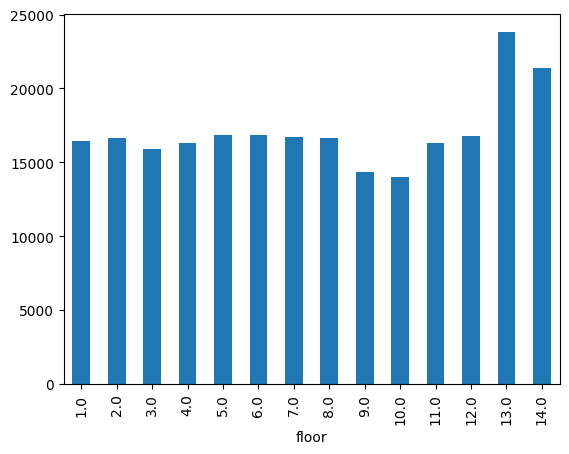

In [55]:
floors.plot(kind='bar');

Only 13th and 14th floor show disproportion in price per m2. Also floor 9 and 10 present lower prices.

Check which floor is most popular for each floorCount

In [56]:
df.groupby('floorCount')['floor'].agg(pd.Series.mode)

,floor
floorCount,
1.0,1.0
2.0,2.0
3.0,3.0
4.0,3.0
5.0,2.0
6.0,1.0
7.0,"[1.0, 7.0]"
8.0,"[1.0, 4.0]"
9.0,4.0


In [57]:
df.groupby('floorCount')['floor'].median()

,floor
floorCount,
1.0,1.0
2.0,2.0
3.0,2.0
4.0,3.0
5.0,3.0
6.0,3.0
7.0,4.0
8.0,4.0
9.0,5.0


The best strategy to fill missing values in 'floor' column will be to use statistical estimation with Random Forest Regressor. There will be a restriction: floor cannot exceed floorCount for the given apartment.

In [58]:
# Split the dataset
data_with_floor = df.dropna(subset=['floor'])  # Rows with known floor
data_missing_floor = df[df['floor'].isna()]  # Rows with missing floor

# Prepare the features and target
X = data_with_floor[['price_per_m2', 'squareMeters', 'floorCount']]
y = data_with_floor['floor']

# Train-Test Split (Optional, for model evaluation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
param_grid = {
    'n_estimators': [70, 80, 90, 100],
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'bootstrap': [True]
}

# Create the RandomForestRegressor model
rf = RandomForestRegressor(random_state=42)

# Apply GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='r2')

# Fit the model
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best R2: ", grid_search.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 80}
Best R2:  0.5260307443711638


In [60]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"R2 Score: {r2_score(y_test, y_pred)}")

RMSE: 1.4558023251859997
R2 Score: 0.5846313964291112


In [61]:
# Predict missing values
X_missing = data_missing_floor[['price_per_m2','squareMeters', 'floorCount']]
missing_predictions = best_model.predict(X_missing)

# Post-process predictions
# Clip predictions to ensure they lie within valid range [1, floorCount]
missing_predictions = missing_predictions.clip(1, X_missing['floorCount'])
# Round to the nearest integer
missing_predictions = missing_predictions.round().astype(int)

# Impute missing values
data_missing_floor['floor'] = missing_predictions

# Combine datasets
df_imputed = pd.concat([data_with_floor, data_missing_floor]).sort_index()

In [62]:
df_imputed.loc[floor_missing.head(10).index.to_list()]

,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,...,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price,locationCategory,price_per_m2
1486,tenement,40.70,2.0,1.0,3.0,1950.0,50.077295,19.932287,2.49,20.0,...,brick,standard,no,no,no,no,no,750000,12,18428.0
1488,blockOfFlats,56.19,3.0,3.0,4.0,1966.0,50.073959,19.968125,2.97,9.0,...,brick,standard,yes,no,no,no,yes,890000,14,15839.0
1490,blockOfFlats,37.00,2.0,3.0,10.0,1970.0,50.086969,20.021469,6.89,23.0,...,concreteSlab,low,no,no,yes,no,yes,459000,2,12405.0
1493,blockOfFlats,50.00,2.0,2.0,4.0,1970.0,50.058611,19.967778,2.13,9.0,...,concreteSlab,premium,yes,yes,no,no,yes,900000,3,18000.0
1494,tenement,42.00,2.0,2.0,4.0,1920.0,50.049417,19.945298,0.82,144.0,...,brick,low,no,yes,no,no,no,749000,6,17833.0
1498,apartmentBuilding,52.00,2.0,3.0,4.0,2023.0,50.068854,19.891525,3.67,1.0,...,brick,premium,yes,yes,yes,yes,no,1227500,19,23606.0
1503,blockOfFlats,53.83,3.0,2.0,2.0,2019.0,50.072556,20.037521,7.33,27.0,...,brick,premium,yes,no,no,no,no,860000,21,15976.0
1508,blockOfFlats,34.00,2.0,2.0,4.0,1963.0,50.079715,20.018985,6.36,18.0,...,brick,standard,no,no,no,no,yes,568000,26,16706.0
1509,blockOfFlats,66.92,3.0,3.0,5.0,2008.0,50.018140,19.889613,5.41,16.0,...,brick,standard,yes,no,no,no,yes,999000,27,14928.0
1512,blockOfFlats,25.00,1.0,3.0,4.0,1968.0,50.082732,19.966835,3.66,13.0,...,concreteSlab,standard,no,no,no,no,yes,424000,28,16960.0


Compare value counts of each floor before and after imputations.

<Axes: xlabel='floor'>

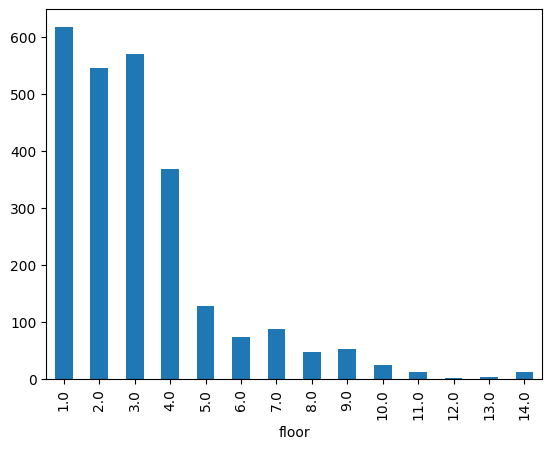

In [63]:
df['floor'].value_counts().sort_index().plot(kind='bar')

<Axes: xlabel='floor'>

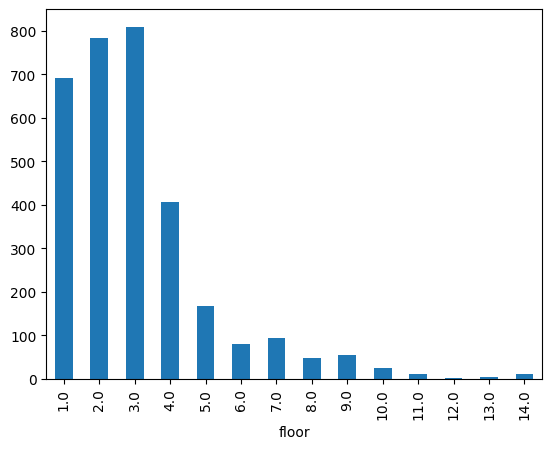

In [64]:
df_imputed['floor'].value_counts().sort_index().plot(kind='bar')

For the floors 1-3 the proportion changed slightly, however most of the missing values were for the floorCount 3 and 4, so values from 1 to 4 could be imputted for them.

In [65]:
df = df_imputed

Check if any new duplicates appeared. If so, delete them.

In [66]:
duplicates = df[df.duplicated(keep=False)]
duplicates

,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,...,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price,locationCategory,price_per_m2
1998,blockOfFlats,49.00,3.0,3.0,3.0,2018.0,49.988570,19.904513,7.81,0.0,...,brick,standard,no,yes,no,no,no,660000,76,13469.0
2176,blockOfFlats,49.00,3.0,3.0,3.0,2018.0,49.988570,19.904513,7.81,0.0,...,brick,standard,no,yes,no,no,no,660000,76,13469.0
2226,blockOfFlats,34.28,2.0,1.0,4.0,1962.0,50.085170,19.966610,3.88,27.0,...,concreteSlab,standard,no,yes,no,no,yes,561000,18,16365.0
3048,blockOfFlats,34.28,2.0,1.0,4.0,1962.0,50.085170,19.966610,3.88,27.0,...,concreteSlab,standard,no,yes,no,no,yes,561000,18,16365.0
4062,apartmentBuilding,55.55,3.0,1.0,5.0,2022.0,50.040908,19.983091,3.57,5.0,...,brick,standard,no,no,yes,no,no,994345,17,17900.0
4685,apartmentBuilding,55.55,3.0,1.0,5.0,2022.0,50.040908,19.983091,3.57,5.0,...,brick,standard,no,no,yes,no,no,994345,17,17900.0


In [67]:
df = df.drop_duplicates()

### Find strategy for filling missing data in '...Distance' columns

In [68]:
df[df['clinicDistance'].isnull()]

,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,...,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price,locationCategory,price_per_m2
2821,tenement,36.00,2.0,1.0,2.0,1950.0,50.043911,19.819437,8.59,4.0,...,brick,premium,yes,no,no,no,yes,529000,150,14694.0
3027,blockOfFlats,33.00,1.0,2.0,2.0,1970.0,50.043833,19.819921,8.56,4.0,...,concreteSlab,standard,no,no,no,no,yes,469000,150,14212.0
3672,blockOfFlats,90.77,3.0,2.0,3.0,2006.0,50.043465,19.817655,8.72,2.0,...,brick,standard,yes,yes,no,no,yes,1190000,150,13110.0
3681,blockOfFlats,91.00,3.0,2.0,2.0,2005.0,50.043504,19.817595,8.73,2.0,...,brick,premium,yes,yes,no,no,no,1260000,150,13846.0
3970,blockOfFlats,33.00,1.0,2.0,2.0,1970.0,50.039100,19.815700,8.95,1.0,...,brick,low,no,no,no,no,yes,497000,164,15061.0
4121,blockOfFlats,39.00,2.0,2.0,2.0,1970.0,50.044063,19.816802,8.77,2.0,...,brick,low,no,no,no,no,no,469000,150,12026.0
4310,blockOfFlats,35.54,2.0,1.0,2.0,1970.0,50.043930,19.819370,8.60,4.0,...,concreteSlab,standard,no,no,no,no,no,499000,150,14041.0
4364,blockOfFlats,55.00,2.0,1.0,1.0,1970.0,50.063083,19.806397,9.47,0.0,...,concreteSlab,standard,no,yes,no,no,yes,825000,168,15000.0


In [69]:
df[df['locationCategory'] == 150]

,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,...,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price,locationCategory,price_per_m2
2821,tenement,36.00,2.0,1.0,2.0,1950.0,50.043911,19.819437,8.59,4.0,...,brick,premium,yes,no,no,no,yes,529000,150,14694.0
3027,blockOfFlats,33.00,1.0,2.0,2.0,1970.0,50.043833,19.819921,8.56,4.0,...,concreteSlab,standard,no,no,no,no,yes,469000,150,14212.0
3672,blockOfFlats,90.77,3.0,2.0,3.0,2006.0,50.043465,19.817655,8.72,2.0,...,brick,standard,yes,yes,no,no,yes,1190000,150,13110.0
3681,blockOfFlats,91.00,3.0,2.0,2.0,2005.0,50.043504,19.817595,8.73,2.0,...,brick,premium,yes,yes,no,no,no,1260000,150,13846.0
4121,blockOfFlats,39.00,2.0,2.0,2.0,1970.0,50.044063,19.816802,8.77,2.0,...,brick,low,no,no,no,no,no,469000,150,12026.0
4310,blockOfFlats,35.54,2.0,1.0,2.0,1970.0,50.043930,19.819370,8.60,4.0,...,concreteSlab,standard,no,no,no,no,no,499000,150,14041.0


### Find strategy for filling missing data in 'hasElevator' column

In [70]:
df['hasElevator'].value_counts(dropna=False)

,count
hasElevator,
no,1583
yes,1500
NaN,103


In [71]:
df.groupby(['type'])['hasElevator'].value_counts(dropna=False)

type               hasElevator
apartmentBuilding  yes             502
                   no              144
                   NaN               6
blockOfFlats       no             1057
                   yes             911
                   NaN              57
tenement           no              382
                   yes              87
                   NaN              40
Name: count, dtype: int64

In [72]:
groupped = df.loc[df['type'] == 'blockOfFlats'].groupby(['buildYear'])['hasElevator'].value_counts()
groupped.tail(20)

buildYear  hasElevator
2015.0     yes            15
           no             10
2016.0     yes            25
           no             14
2017.0     yes            42
           no             15
2018.0     yes            59
           no             26
2019.0     yes            23
           no              8
2020.0     yes            35
           no             10
2021.0     yes            19
           no             13
2022.0     yes            45
           no             18
2023.0     yes            82
           no             33
2024.0     yes            41
           no             28
Name: count, dtype: int64

The strategy for filling missing values will be to find the most dominant value for the same type and buildYear. If there is no such value, use the most dominant value for only the same type.

In [73]:
#Group by locationCategory and type to compute mode
grouped = df.groupby(["type", "buildYear"])["hasElevator"]

#Calculate mode for each group
mode_by_group = grouped.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

#Function to get fill value for a given buildYear and type
def get_fill_value(row):
    if not pd.isna(row["hasElevator"]):
        return row["hasElevator"]

    #Try to get mode for the group
    mode = mode_by_group.get((row["type"], row["buildYear"]), None)
    if mode is not None and not pd.isna(mode):
        return mode


    #Fallback to mode for the type across the whole dataset
    type_mode = df[df["type"] == row["type"]]["hasElevator"].mode()
    if not type_mode.empty:
        return type_mode.iloc[0]

#Apply function to fill missing hasElevator values
df["hasElevator"] = df.apply(get_fill_value, axis=1)


### Divide [...]Distance columns into the bins

In [74]:
distance_columns = [col for col in df.columns if 'Distance' in col]
distance_columns

['centreDistance',
 'schoolDistance',
 'clinicDistance',
 'postOfficeDistance',
 'kindergartenDistance',
 'restaurantDistance',
 'collegeDistance',
 'pharmacyDistance']

In [75]:
df[distance_columns].describe()

,centreDistance,schoolDistance,clinicDistance,postOfficeDistance,kindergartenDistance,restaurantDistance,collegeDistance,pharmacyDistance
count,3186.000000,3186.000000,3178.000000,3186.000000,3186.000000,3186.000000,3161.000000,3185.000000
mean,4.160053,0.381960,0.816746,0.426692,0.360702,0.271926,1.333533,0.329811
std,2.240918,0.284053,0.631945,0.319667,0.318338,0.249811,1.000933,0.317236
min,0.220000,0.008000,0.009000,0.013000,0.004000,0.002000,0.006000,0.003000
25%,2.160000,0.177000,0.392000,0.225000,0.161000,0.105000,0.559000,0.138000
50%,4.110000,0.297000,0.656000,0.354000,0.271500,0.212000,1.060000,0.238000
75%,5.807500,0.495000,1.085500,0.518000,0.457000,0.360000,1.886000,0.395000
max,9.980000,1.915000,4.887000,2.397000,2.727000,2.037000,4.989000,2.635000


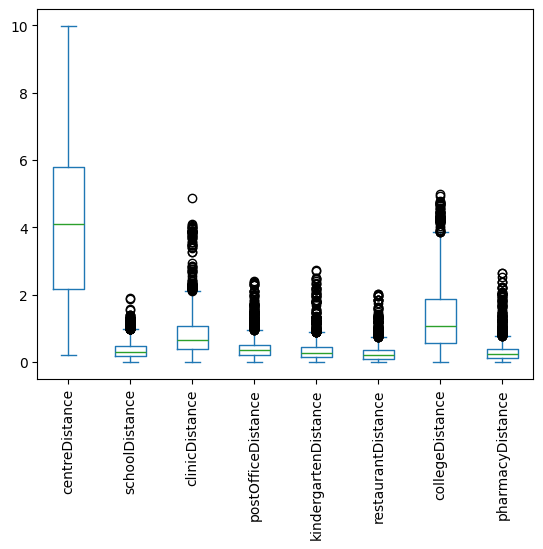

In [84]:
df[distance_columns].plot(kind='box')
plt.xticks(rotation=90);

centreDistance column has a slightly different scale so it will be treated separately.

In [85]:
distance_columns.remove('centreDistance')

Try to split into 10 bins based on the most spread column

In [92]:
max_column = df[distance_columns].max().idxmax()
max_val = df[max_column].max()

bins = np.linspace(0, max_val, 11)

for col in distance_columns:
    df[f'{col}_binned'] = pd.cut(df[col], bins=bins, labels=False, include_lowest=True)

In [95]:
distance_columns_binned = [col+'_binned' for col in distance_columns]
distance_columns_binned

['schoolDistance_binned',
 'clinicDistance_binned',
 'postOfficeDistance_binned',
 'kindergartenDistance_binned',
 'restaurantDistance_binned',
 'collegeDistance_binned',
 'pharmacyDistance_binned']

In [97]:
df['schoolDistance_binned'].value_counts()

,count
schoolDistance_binned,
0,2396
1,634
2,152
3,4


In [99]:
df['clinicDistance_binned'].value_counts()

,count
clinicDistance_binned,
1.0,1149
0.0,1128
2.0,496
3.0,259
4.0,89
7.0,27
5.0,13
6.0,9
8.0,7


In [98]:
df['collegeDistance_binned'].value_counts()

,count
collegeDistance_binned,
1.0,849
0.0,664
2.0,581
3.0,359
4.0,288
5.0,162
6.0,99
7.0,78
8.0,63


# Feature Selection

### Check 'ownership' column

In [71]:
df['ownership'].value_counts(normalize=True)

,proportion
ownership,
condominium,0.933773
cooperative,0.065913
udział,0.000314


Over 93% of 'ownership' is condominium which suggest it is a quasi-constant feature. Column will be removed

In [72]:
df = df.drop(columns=['ownership'])

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3186 entries, 1475 to 4719
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  3186 non-null   object 
 1   squareMeters          3186 non-null   float64
 2   rooms                 3186 non-null   float64
 3   floor                 3186 non-null   float64
 4   floorCount            3186 non-null   float64
 5   buildYear             3186 non-null   float64
 6   latitude              3186 non-null   float64
 7   longitude             3186 non-null   float64
 8   centreDistance        3186 non-null   float64
 9   poiCount              3186 non-null   float64
 10  schoolDistance        3186 non-null   float64
 11  clinicDistance        3178 non-null   float64
 12  postOfficeDistance    3186 non-null   float64
 13  kindergartenDistance  3186 non-null   float64
 14  restaurantDistance    3186 non-null   float64
 15  collegeDistance       3

### Check for multicolinearity

<Axes: >

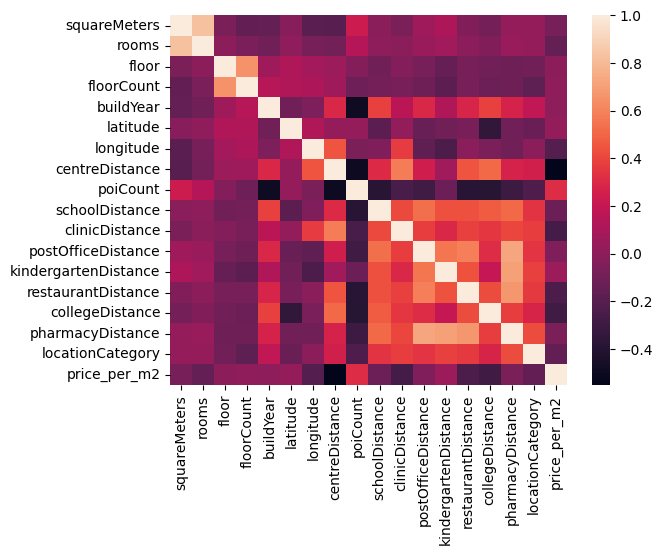

In [77]:
corr = df.select_dtypes('number').drop(columns='price').corr()
sns.heatmap(corr)

Drop 'rooms' and 'floorCount' columns as they are highly corelated with other columns

In [78]:
df = df.drop(columns=['rooms', 'floorCount'])

### Prepare for model

In [ ]:
df.replace({'yes': 1, 'no': 0}, inplace=True)

# PLACEHOLDER

In [ ]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline

# Build model

In [ ]:
target = 'price'
X = df.drop(columns=target)
y = df[target]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2548, 24)
y_train shape: (2548,)
X_test shape: (637, 24)
y_test shape: (637,)


Calculate baseline MAE

In [ ]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_pred_baseline, y_train)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 936036.5090266876
Baseline MAE: 302454.0242212934


### Linear Regression

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

ValueError: could not convert string to float: 'blockOfFlats'

In [ ]:
y_train_pred = model.predict(X_train)
y_train_mae = mean_absolute_error(y_train, y_train_pred)
print("Train MAE:", y_train_mae)

In [ ]:
y_test_pred = model.predict(X_test)
y_test_mae = mean_absolute_error(y_test, y_test_pred)
print("Test MAE:", y_test_mae)

In [ ]:
model.coef_

## Ridge

In [ ]:
new_model = Ridge()

In [ ]:
y_train_pred = new_model.predict(X_train)
y_train_mae = mean_absolute_error(y_train, y_train_pred)
print("Train MAE:", y_train_mae)

In [ ]:
param_grid = {'alpha': np.logspace(-3, 3, 50)}

grid_search = GridSearchCV(new_model, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

In [ ]:
best_alpha = grid_search.best_params_['alpha']
best_score = -grid_search.best_score_  # Convert back to positive MAE

print(f"Best alpha: {best_alpha}")
print(f"Best CV MAE: {best_score:.2f}")

In [ ]:
y_test_pred = new_model.predict(X_test)
y_test_mae = mean_absolute_error(y_test, y_test_pred)
print("Test MAE:", y_test_mae)

In [ ]:
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train, y_train)

# Evaluate on the test set
y_pred = ridge_best.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print(f"Test MAE: {test_mae:.2f}")

In [ ]:
new_model.coef_

## Decision Tree

Placeholder

## Random Forest

Placeholder